In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 54.0MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
pip install Keras==2.3.1

     |████████████████████████████████| 378kB 8.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: opt-einsum, tensorboard, numpy, six, absl-py, grpcio, wheel, scipy, google-pasta, protobuf, termcolor, wrapt, tensorflow-estimator, keras-preprocessing, astunparse, gast, h5py
Required-by: fancyimpute


In [4]:
pip show keras

Name: Keras
Version: 2.3.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: h5py, pyyaml, numpy, keras-applications, scipy, six, keras-preprocessing
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
data=np.load('/content/drive/MyDrive/otherdisease/data.npy')
target=np.load('/content/drive/MyDrive/otherdisease/target.npy')

In [7]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [10]:

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]
#parrale 2d conv layer 128@3x3 128@5x5 128@7x7
parralel_kernels=[3,5,7]
for k in range(len(parralel_kernels)):

    conv = Conv2D(128, parralel_kernels[k],border_mode='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(input=inp, output=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
#use dropout for minimize overfitting
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
#use softmax as activiton of output layer since probability we need COVID19 & Negative
model.add(Dense(3,input_dim=128,activation='softmax'))

#categorical crossentropy use for specifictaion type problem
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation_3 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        18464     
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 3, activation="relu", input_shape=(100, 100,..., strides=1, padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 5, activation="relu", input_shape=(100, 100,..., strides=1, padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 7, activation="relu", input_shape=(100, 100,..., strides=1, padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  del sys.path[0]


In [11]:
from sklearn.model_selection import train_test_split
#as we see 10% testing go to testing and 90% go to the training 
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [12]:
#save all the nueral model here then moniter validation and then we save best only
#val-loss for minimum validation loss
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
#10 percent use as validation
#increasing epochs we increase the neural neural
history=model.fit(train_data,train_target,epochs=200,callbacks=[checkpoint],validation_split=0.1)

Train on 3730 samples, validate on 415 samples
Epoch 1/200
3730/3730 [==============================] - 24s 6ms/step - loss: 0.9378 - accuracy: 0.5641 - val_loss: 0.7720 - val_accuracy: 0.6386
Epoch 2/200
3730/3730 [==============================] - 13s 4ms/step - loss: 0.8158 - accuracy: 0.5973 - val_loss: 0.6564 - val_accuracy: 0.6386
Epoch 3/200
3730/3730 [==============================] - 13s 4ms/step - loss: 0.7228 - accuracy: 0.6517 - val_loss: 0.5690 - val_accuracy: 0.7614
Epoch 4/200
3730/3730 [==============================] - 13s 4ms/step - loss: 0.6178 - accuracy: 0.7147 - val_loss: 0.4720 - val_accuracy: 0.7904
Epoch 5/200
3730/3730 [==============================] - 13s 4ms/step - loss: 0.5306 - accuracy: 0.7697 - val_loss: 0.3771 - val_accuracy: 0.8410
Epoch 6/200
3730/3730 [==============================] - 14s 4ms/step - loss: 0.4312 - accuracy: 0.8308 - val_loss: 0.6811 - val_accuracy: 0.6578
Epoch 7/200
3730/3730 [==============================] - 13s 4ms/step - loss:

In [17]:
from matplotlib import pyplot as plt

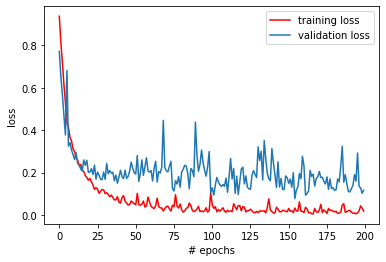

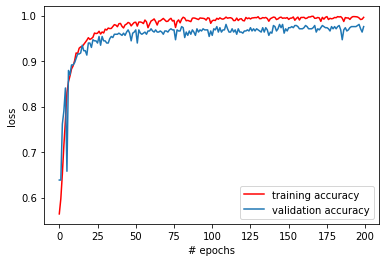

In [18]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
print(model.evaluate(test_data,test_target))

461/461 [==============================] - 1s 1ms/step
[0.06252401227175931, 0.9718004465103149]


In [20]:
model.save('model_save_200epoch.h5')